<div align="center">
    <H1>
        <Strong>
            Analysis on Hero Compositions in Overwatch
        </Strong>
    </H1>
    Chinhnam Nguyen, Jared Fleming, Ben Fleming
</div>

---

<div align="center">
    <H1>
        <Strong>
            Introduction
        </Strong>
    </H1>
</div>

Overwatch is a multiplayer team-based first-person shooter developed and published by Blizzard Entertainment and published in 2016. It skyrocketed in popularity quickly after release and is still going strong with over 5 million average players each month in 2021, and peaking as high as 7.3 million. Described as a "hero shooter", Overwatch assigns players into two teams of six, with each player selecting from a large roster of characters, known as "heroes", with unique abilities. Teams work to complete map-specific objectives within a limited period of time such as pushing a payload across the map or holding an area longer than the other team.

The meteoric rise in popularity also inspired both Blizzard and esports organizations to arrange their own teams and tournaments, resulting in the Overwatch League, which is produced and regulated by Blizzard themselves. Though based in the U.S., the league also features teams from Asia and Europe, resulting in 20 city-based teams, each with a max roster of 12 players. Due to its wide interchangeability between maps, gamemodes, and hero compositions (the heroes picked by each team), Overwatch is one of the most analyzed competitive games in the world. To help with this, Blizzard compiles and publicly releases the data collected throughout professional play during the year. All of the datasets can be accessed [here](https://overwatchleague.com/en-us/statslab "Overwatch League Stats Lab").

Here, we will be focusing on the data collected during the 2020 Overwatch League season, and will primarily intend to figure out the most optimal hero compositions for each map and gamemode. Heroes are meant to compliment and check each other as they are split into three classes: damage, support, and tank. Obviously, we would expect a team of six attack heroes to succeed in aggressing the enemy, but would also expect them to fail miserably when defending an area. This is why finding a correct and balanced composition is integral to the game, and professional play in general.

<center><img src="gallery.jpg" alt="Hero's Gallery" width="700"></center>

---

<div align="center">
    <H1>
        <Strong>
            Exploring the Dataset
        </Strong>
    </H1>
</div>

<H3>
    <Strong>
        Libraries
    </Strong>
</H3>

We will be utilizing Python 3 along with various data science libraries: [pandas](https://pandas.pydata.org/), [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<H3>
    <Strong>
        Processing the Data
    </Strong>
</H3>

Blizzard released the data for 2020 in two files, one for the first half and the other for the second half, due to its immense size (over 1.2 million rows). The dataset comes in the form of a CSV file.

In [2]:
# Reading in both datasets and combine into one dataframe
players1, players2 = pd.read_csv("phs_2020/phs_2020_1.csv"), pd.read_csv("phs_2020/phs_2020_2.csv")
data = pd.concat([players1, players2])
data.head()

,start_time,esports_match_id,tournament_title,map_type,map_name,player_name,team_name,stat_name,hero_name,stat_amount
0,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,All Damage Done,All Heroes,6674.164055
1,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Assists,All Heroes,11.000000
2,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Average Time Alive,All Heroes,60.199502
3,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Barrier Damage Done,All Heroes,1875.000000
4,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Damage Blocked,All Heroes,14640.911780


We can see that the raw dataset present us with a myriad of problems. Firstly, it includes data collected outside of the OWL 2020 Regular Season, which we will not be considering. Another issue is that `stat_name` is presented as it's own column instead of their own individual and respective columns. This will make it difficult for us to understand and view the dataset as well as accessing player statistics. We will be dropping the `start_time` column as it is irrelevant to what we are depicting, along with all rows that record the cumulative statistics for a player on all heroes (`hero_name == All Heroes`), since we are looking to compare individual hero statistics. To make things simpler, we will conglomerate a player's stats with a hero across games in a match, meaning if a player plays as a hero more than once for the same `match_id`, we will average their statistics across the games into one row. The dataset also includes a multitude of irrelevant statistics that we will need to remove, such as `Environmental Kills` i.e. number of times the player knocks an enemy off of the map. To recap, there are five things we need to do to sanitize the data:
1. Drop all non OWL 2020 Regular Season rows
2. Pivot the table to turn stat_name into columns with stat_amount as values
3. Drop `start_time`
4. Drop all `hero_name == All Heroes` rows
5. Drop all irrelevant statistics

<H3>
    <Strong>
        Tidying the Dataset
    </Strong>
</H3>

First, lets drop all irrelevant columns and rows and rearrange the columns into a more readable format.

In [3]:
# Drop irrelevant columns and rows
data.drop(['start_time'], axis=1)
data.drop(data.index[data['tournament_title'] != 'OWL 2020 Regular Season'], inplace=True)
data.drop(['tournament_title'], axis = 1, inplace = True)
data = data.reindex(columns = ['esports_match_id', 'map_type', 'map_name', 'player_name', 'team_name', 'hero_name', 'stat_name', 'stat_amount'])
data = data[data["hero_name"] != "All Heroes"]
stats = ['Hero Damage Done', 'Assists', 'Barrier Damage Done', 'Deaths', 'Eliminations', 'Objective Kills', 'Objective Time', 'Ultimates Earned - Fractional', 'Final Blows', 'Damage Blocked', 'Healing Done', 'All Damage Done']
data = data.loc[data['stat_name'].isin(stats)]
data['stat_amount'] = data['stat_amount'].round(decimals = 2)
data.head()

,esports_match_id,map_type,map_name,player_name,team_name,hero_name,stat_name,stat_amount
22,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,All Damage Done,6674.16
23,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,Assists,11.00
25,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,Barrier Damage Done,1875.00
31,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,Damage Blocked,14640.91
33,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,Deaths,5.00


The dataframe already looks much better but we're not done yet. Now we can pivot the table to turn `stat_name` into columns and `stat_amount` into rows.

In [4]:
# Tidy dataset to elongate stat_name column into rows and insert respective stat_amount values
data = data[['stat_name', 'stat_amount', 'player_name','esports_match_id','hero_name','map_name', 'team_name']].copy().reset_index()
data = data.pivot_table(values='stat_amount', index=[data['esports_match_id'],data['team_name'], data['player_name'], data['map_name'], data['hero_name']], columns='stat_name', aggfunc='sum')
data = data.fillna(0).reset_index()
data.rename(columns = {'Ultimates Earned - Fractional':'Ultimates Earned', 'esports_match_id':'match_id'}, inplace = True)
data['map_name'].replace({'King\'s Row': 'Kings Row'}, inplace = True)
data.head()

stat_name,match_id,team_name,player_name,map_name,hero_name,All Damage Done,Assists,Barrier Damage Done,Damage Blocked,Deaths,Eliminations,Final Blows,Healing Done,Hero Damage Done,Objective Kills,Objective Time,Ultimates Earned
0,30991,Paris Eternal,BenBest,Eichenwalde,Reinhardt,14495.63,10.0,5517.72,32655.81,9.0,19.0,9.0,0.00,8976.92,10.0,295.96,7.97
1,30991,Paris Eternal,BenBest,Havana,Reinhardt,9921.49,6.0,3075.00,21137.18,11.0,10.0,4.0,0.00,6837.43,3.0,148.89,5.15
2,30991,Paris Eternal,BenBest,Horizon Lunar Colony,Reinhardt,12362.02,13.0,3236.46,19394.67,10.0,21.0,8.0,0.00,8945.56,8.0,114.43,6.52
3,30991,Paris Eternal,BenBest,Lijiang Tower,Reinhardt,6674.16,11.0,1875.00,14640.91,5.0,13.0,2.0,0.00,4798.16,9.0,65.05,3.71
4,30991,Paris Eternal,FDGod,Eichenwalde,Lúcio,12012.14,14.0,5175.00,0.00,9.0,18.0,2.0,9229.73,6836.14,9.0,167.42,7.03


Here, we can see that the finalized dataset we will be analyzing has five objective columns and twelve stat columns.  
<Strong>Objective Columns:</Strong>
* `match_id` - The number referencing the matches in which the player earned the stats. A series of matches will have the same match_id.
* `team_name` - Name of the team of the player.
* `player_name` - In-game name of the player.
* `map_name` - Names of the maps on which the games were played.
* `hero_name` - Names of the heroes that the player played as.

<Strong>Stat Columns:</Strong>
* `All Damage Done` - Total damage done by the player in the match.
* `Assists` - Enemy deaths that the player participated in but did not achieve the final blow.
* `Barrier Damage Done` - Damage done by player only to enemy barriers.
* `Damage Blocked` - Damage blocked by the player's barriers (will only apply to barrier heroes).
* `Deaths` - Total death count of the player.
* `Eliminations` - Total number of enemy deaths that the player participated in.
* `Final Blows` - Enemy deaths in which the player achieved the final blow.
* `Healing Done` - Total personal and team health points healed by the player (will only apply to healing heroes).
* `Hero Damage Done` - Damage done only to enemy heroes.
* `Objective Kills` - Eliminations made by the player where the enemy was either at the objective point, or the player was defending the objective point.
* `Objective Time` - Time spent by the player either defending or attacking the objective point.
* `Ultimates Earned` - Total ultimate abilities earned by the player.

<center><img src="pros.jpeg" alt="Hero's Gallery" width="600"></center>

---

<div align="center">
    <H1>
        Exploratory Data Analysis
    </H1>
</div>

<H3>
    <Strong>
        Determining Best Heroes per Class
    </Strong>
</H3>

In order to determine the best heroes for each class, one could spend a lot of time manually testing and collecting DPS (damage per second), healing ability, movement capability, and a horde of other statistics, and then compare them to one another, then do another round of in-game testing to take into account player and map variability, etc. However, as poor college students trying to make it through finals, we do not have this time. We can, however, have other people test out the heroes, find their weaknesses and strengths, and determine their overall playability. Professional players are the best of the best. They practice everyday and are constantly limit-testing heroes to their fullest capability. As a result, we can look to them to tell us who the best heroes are.

<H3>
    <Strong>
        Which heroes do the best players play?
    </Strong>
</H3>

In order to determine which heroes are most frequently used by professional players, we will first split the available hero gallery into their respective classes. We will then determine the <b>Efficiency</b> of each player compared to other players playing in the same class by applying an equation that takes into account all of the statistics available in the dataframe. Because different classes are meant to emphasize different statistics, we will be applying different efficiency equations for each class. We will then graph the efficiencies of each player for each class in order to compare them to their teammates as well as their oponents.

In [5]:
# Ignore map and average stats and prepare to plot efficiencies of each team per class
average_table = data.drop('map_name', axis=1, inplace=False)
average_table = average_table.groupby(['match_id', 'team_name', 'player_name', 'hero_name']).mean().reset_index()
teams = average_table['team_name'].unique()

# Split the heroes by their class
damagers = ['Ashe', 'Bastion', 'McCree', 'Echo', 'Genji', 'Hanzo', 'Junkrat', 'Mei', 'Pharah', 'Reaper', 'Soldier: 76', 'Sombra', 'Symmetra'
           'Torbjörn', 'Tracer', 'Widowmaker']
tanks = ['D.Va', 'Doomfist', 'Orisa', 'Reinhardt', 'Roadhog', 'Sigma', 'Winston', 'Wrecking Ball', 'Zarya']
supports = ['Ana', 'Baptiste', 'Brigitte', 'Lúcio', 'Mercy', 'Moira', 'Zenyatta']

**Efficiency Equations for each Class:**

Damage heroes are responsible for seeking out, engaging, and defeating the enemy using their varied tools and abilities. It is up to the damage heroes to secure kills. Because of this, we will add more weight to `Assists`, `Barrier Damage Done`, `Eliminations`, `All Damage Done`, `Final Blows`, and `Objective Kills`.
* Damage Efficiency = 2(Ass.) + 2(Barrier Dam.) - 1.5(Deaths) + 2.5(Eliminations) + 2(All Dam.) + 2(Final Blows) + (Healing Done) + 2(Obj Kills) + (Obj Time) + 1.5(Ults Earned)

Support heroes empower their allies by healing them, boosting their damage, and providing vital utility. They act as the backbone of the team's survival. For this reason we will add more weight to `Assists`, `Healing Done`, `Objective Kills`, `Objective Time`, and `Ultimates Earned`, and penalize stronger for `Deaths`.
* Support Efficiency = 2(Ass.) + 1.5(Barrier Dam.) - 2(Deaths) + 1.5(Eliminations) + (All Dam.) + (Final Blows) + 2.5(Healing Done) + 1.5(Obj Kills) + (Obj Time) + 1.5(Ults Earned)

Tanks specialize in protecting allies, disrupting enemies, and occupying the front line. They have high survivability and abilities that protect themselves and others with shields and crowd control. As a result, we will add more weight to `Assists`, `Damaged Blocked`, `Eliminations`, `All Damage Done`, `Objective Kills`, `Objective Time`, and penalize much harder for `Deaths`.
* Tank Efficiency = 1.5(Ass.) + (Barrier Dam.) + 1.5(Dam. Blocked) - 3(Deaths) + 2(Eliminations) + 1.5(All Dam.) + (Final Blows) + (Healing Done) + 1.5(Obj Kills) + 2(Obj Time) + (Ults Earned)

Now that we have determined our equations for each class, we can now calculate the effiencies of each player and then graph the results. This will show us which players are the best at each class, and from there we can find the most frequently used heroes chosen by the most efficient players.

stat_name               team_name player_name      match_id  All Damage Done  \
2                   Atlanta Reign       Saucy  34795.416667     19240.560833   
6                 Boston Uprising       Jerry  33956.174603      9383.616732   
8                 Chengdu Hunters   Baconjack  33637.473684      8797.774474   
12                    Dallas Fuel        Doha  34164.525424     10132.934059   
14                 Florida Mayhem        Yaki  34250.388889     12359.940713   
19               Guangzhou Charge        nero  33776.942857     11245.667886   
22                 Hangzhou Spark   Architect  34782.405405     11262.023559   
26                Houston Outlaws   Hydration  31919.600000     12041.194167   
29                London Spitfire    Although  34642.714286     14111.075405   
34         Los Angeles Gladiators        Jaru  32827.000000     11267.666429   
38            Los Angeles Valiant         KSF  34090.960000     14941.366607   
42             New York Excelsior      H

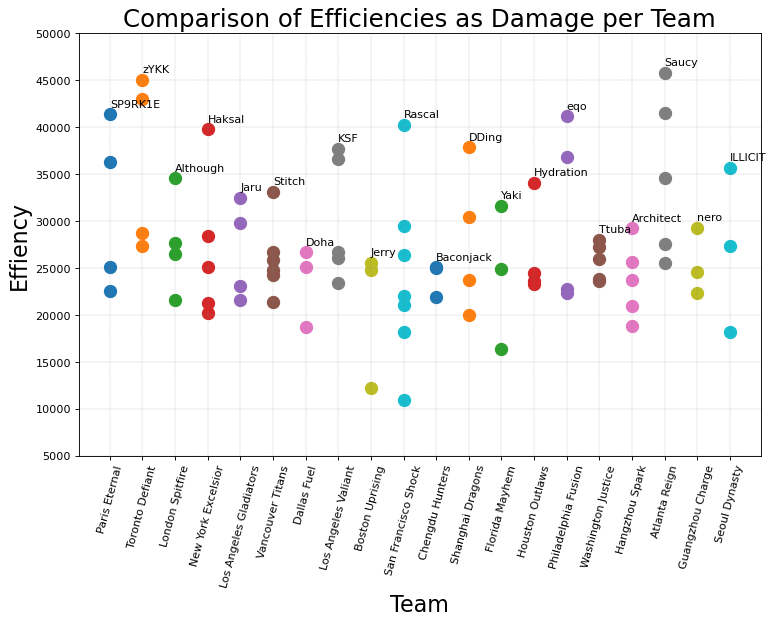

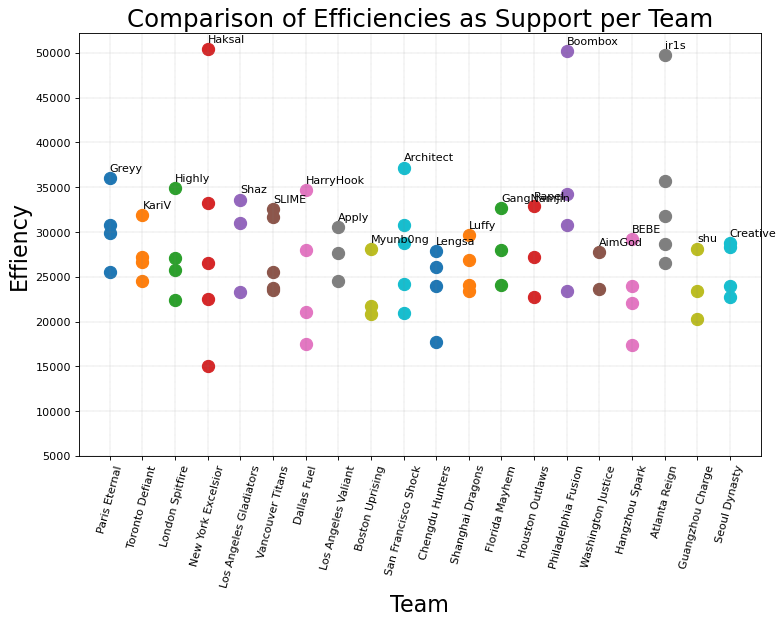

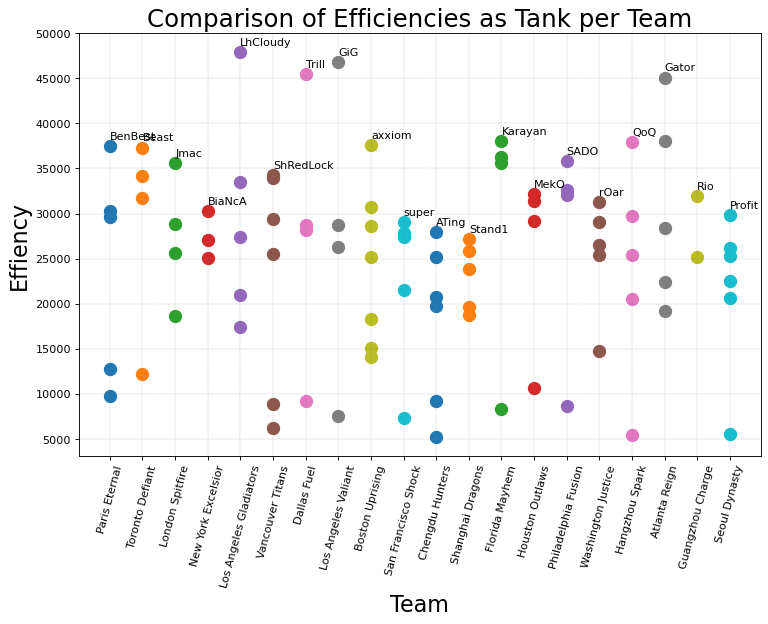

In [32]:
classes = ['Damage', 'Support', 'Tank']
for curr_class in classes:
    # Take rows of only heroes of the current class
    if (curr_class == 'Damage'):
        curr_table = average_table.loc[average_table['hero_name'].isin(damagers)].copy()
    elif (curr_class == 'Support'):
        curr_table = average_table.loc[average_table['hero_name'].isin(supports)].copy()
    else:
        curr_table = average_table.loc[average_table['hero_name'].isin(tanks)].copy()

    # Define equations we will use to calculate overall efficiency and create efficiency column
    def healer_efficiency(row, clas):
        if (clas == 'Damage'):
            return (2*row['Assists'] + 2*row['Barrier Damage Done'] - 1.5*row['Deaths'] + 2.5*row['Eliminations'] + 2*row['All Damage Done']
                    + 2*row['Final Blows'] + row['Healing Done'] + 2*row['Objective Kills'] + row['Objective Time'] + 1.5*row['Ultimates Earned'])
        elif (clas == 'Support'):
            return (2*row['Assists'] + 1.5*row['Barrier Damage Done'] - 2*row['Deaths'] + 2*row['Eliminations'] + row['All Damage Done']
                    + row['Final Blows'] + 2.5*row['Healing Done'] + 1.5*row['Objective Kills'] + 1.5*row['Objective Time'] + 1.5*row['Ultimates Earned'])
        else:
            return (1.5*row['Assists'] + row['Barrier Damage Done'] + 1.5*row['Damage Blocked'] - 3*row['Deaths'] + 2*row['Eliminations'] + row['All Damage Done']
                    + row['Final Blows'] + row['Healing Done'] + 1.5*row['Objective Kills'] + 1.5*row['Objective Time'] + row['Ultimates Earned'])
            
    curr_table['Efficiency'] = curr_table.apply(lambda row: healer_efficiency(row, curr_class), axis=1)

    # Ignore rows with less than 2000 efficiency as that probably means the player only played as the healer for a short period of time
    # and drop newly irrelevant columns
    curr_table = curr_table[curr_table.Efficiency > 5000].groupby(['team_name', 'player_name']).mean().reset_index()
    best_effiency_table = curr_table.loc[curr_table.groupby('team_name')['Efficiency'].idxmax()]

    # Plot efficiencies of each player for each team
    plots = plt.figure(figsize=(11,7), dpi=80).subplots()
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.2)
    for team in teams:
        plots.scatter(curr_table.loc[curr_table['team_name'] == team]['team_name'].tolist(), curr_table.loc[curr_table['team_name'] == team]['Efficiency'].tolist(), label=team, s=120)
    for index, row in best_effiency_table.iterrows():
        plots.annotate(row['player_name'], (row['team_name'], row['Efficiency']), xytext=(row['team_name'], row['Efficiency'] + 750))
    plots.set_xticklabels(teams, rotation=75)
    plots.set_xlabel('Team', fontsize=20)
    plots.set_ylabel('Effiency', fontsize=20)
    plots.set_yticks([5000,10000,15000,20000,25000,30000,35000,40000,45000,50000])
    plots.set_title('Comparison of Efficiencies as ' + curr_class + ' per Team', fontsize=22)

These graphs allow us to easily see the most efficient players for each team on each class. Notably, we can see that one support player in particular stands out: Haksal. In fact, we could've seen this coming as Haksal, now retired, was regarded as one of the greatest Genji and Brigitte players of all time. His impact as a damage and support character gave New York Excelsior a huge upper hand against their opponents as the year before he had won the OWL's first Rookie of the Year award, and was named both an OWL Role Star and All-Star.

Now we see who are the most efficient players on each team, and from there we can analyze their character usage